<h1><center>BBM469 - DSCP : Cryptocurrency Trading Based on Crowd Hype</center></h1> 

#### Student no : 21827775             
#### Student name : Ali Argun Sayılgan
##### 
#### Student no : 21827723             
#### Student name : Cihad Özcan

<b>Abstract :</b> Our goal is to reveal an indicator for trading, using current movements in messaging platforms. For that purpose, we hope to be able to analyze the hype for different cryptocurrencies, using NLP techniques at messages inside crypto trading discussion groups at <u><i>Telegram</i></u>. By considering interaction rates and utilizing sentiment analysis, we  tried to find out a correlation between the price change of an asset and how the community sees it. We have focused on the top Telegram groups that were oficially created by cryptocurrency exchange platforms. 

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

#### What affects cryptocurrency prices?

In an ideal world, we can expect to find a function like  <i>f(x1, x2, x3, x4, …) = y</i>. But of course such a complicated -and valuable- mission is not that straightforward to accomplish. There are so many factors and they have very complex associations between each other. While crypto markets are getting much bigger, defining these factors get more and more attention. Below, a table is provided from a meta-analysis \[1\], that shows which factors were used for price prediction in various papers and which of them were reported as meaningful:

![Factors used in price prediction](images/factors_used.png)

Cryptocurrencies are values whose price is determined by people's perception. Therefore, it is quite reasonable to predict that there is a relationship between the idea of the community and general trends, in other words, hype.

In recent years, an increasing number of studies have been conducted on the subject. And yes, some of them finds out a considerable correlation between community opinion and cryptocurrency price changes [2 - 6]. There are also some commercial organizations that claim to use open source data accurately with sentiment analysis and predict future price changes [7, 8]. Below, a plot from one of those products, Augmento [9], is shown, which indicates that sentiment analysis provides a great opportunity for predictions.

![Augmento Prediction Plot](images/augmento.png)

Despite everything we talked about, these researches or products mostly focus on different sources than ours; Google search volume, Twitter, forums like Reddit and Bitcointalk etc. Hence, we wanted to search for this relatively understudied data source, Telegram. Eventually, we tried to find out an indicator to predict future behaviours of the trading community, to make profit. For that purpose, we inferred “hype” from shared opinions of others who use Telegram groups.

As a further improvement, we had planned to use data from different discussion platforms like <i>Reddit</i>, <i>Twitter</i> etc. and make some platform-wise comparisons, too. But since we haven't been able to succeed for our main target Telegram, we haven't used data from other social media environments.

#### Our Approach: Sentiment Analysis

Sentiment analysis, also called opinion mining, is the field of study that analyzes people’s opinions and emotions (often classified as positive sentiment, negative, or neutral)  towards a topic or phenomenon. It represents a large problem space and it is useful for many applications. [10]

Why is it so difficult to conduct a sentiment analysis? [11, 12]
1. Sarcasm: Depending on the senders or situations, the words or text data implied in a sarcastic sentence have a different meaning. Sarcasm is when you say something that is the polar opposite of what you want to say.
2. Decoding — What is the sentence’s subject and object, and to whom does the verb or adjective relate?
3. Named Entity Recognition — What exactly is the person talking about, e.g. is 300 Spartans a group of Greeks or a movie?
4. Informal language -capital letters, misspelt or slang words, punctuation, abbreviations, and unexpected grammatical structures.


## Data Understanding<a class="anchor" id="data_understanding"></a>

To determine which Telegram groups to use, we made personal analyses. Some most crowded groups are created for sharing trading signals and they don't give chat permission to other users. Since only admins share technical information, they were not useful. There were some groups that seem like sharing tips but they were full of scammers and conversation wasn't helpful at all. Only groups we found acceptable was those belong to official crypto exchange communities since they had active admins. So that, we considered the biggest 6 exchange communities groups, which are; Binance[13], Kucoin[14], Bittrex[15], Okex[16], Huobi[17] and Brass[18].

We utilized <i>telethon library</i> to download groups' chat history. As an example code, I utilized a repository[19] but needed to rewrite main while loop which fetches data from start.

### Creating Telegram Messages Dataset

In [ ]:
!pip install telethon
import configparser
import json
import asyncio
import pytz

from datetime import date, datetime

from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (PeerChannel)

# some functions to parse json date
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()

        if isinstance(o, bytes):
            return list(o)
        return json.JSONEncoder.default(self, o)


# Reading Configs
config = configparser.ConfigParser()
config.read("config.ini")

# Setting configuration values
api_id = config['Telegram']['api_id']
api_hash = config['Telegram']['api_hash']

api_hash = str(api_hash)

phone = config['Telegram']['phone']
username = config['Telegram']['username']

# Create the client and connect
client = TelegramClient(username, api_id, api_hash)

async def main(phone):
    await client.start()
    print("Client Created")
    # Ensure you're authorized
    if await client.is_user_authorized() == False:
        await client.send_code_request(phone)
        try:
            await client.sign_in(phone, input('Enter the code: '))
        except SessionPasswordNeededError:
            await client.sign_in(password=input('Password: '))

    me = await client.get_me()

    user_input_channel = 'https://t.me/Brass_Exchange_Chat'

    if user_input_channel.isdigit():
        entity = PeerChannel(int(user_input_channel))
    else:
        entity = user_input_channel

    channel = await client.get_entity(entity)

    offset_id = 0
    limit = 1000
    all_messages = []
    total_messages = 0
    total_count_limit = 0
    offset_date=datetime(2020, 1, 1, tzinfo=pytz.UTC) # Optional start date
    flag = False

    while True:
        print("Current Offset ID is:", offset_id, "; Total Messages:", total_messages)
        messages = await client.get_messages(channel, offset_id=offset_id, limit=limit)
        if not messages:
            break
        print("Last message obtained is at: ", messages[-1].date)
        for message in messages:
            # if(message.date < offset_date):
            #    flag = True
            #    break
            all_messages.append(message.to_dict())
        if flag:
            break
        offset_id = messages[len(messages) - 1].id
        total_messages = len(all_messages)
    
    with open('channel_messages.json', 'w') as outfile:
        json.dump(all_messages, outfile, cls=DateTimeEncoder)

with client:
    client.loop.run_until_complete(main(phone))

Although all our efforts, we noticed that nearly all targeted groups provide only some part of their history. Available starting dates are shown below. We downloaded data beginning from today to these dates:
- Okex Start date:  2021-05-06 
- Kucoin Start date:  2021-10-31
- Binance Start date:  2021-05-27
- Bittrex Start date: 2021-01-01
- Huobi Start date: 2021-01-01
- Brass Start date:  2022-01-14

We didn't think that this data would be enough, and searched for more. Kaggle had a dataset [20] created on 2021-01-27, so its data went further back than we could reach. We downloaded this dataset and concatenated our new data with that. But there was some gaps between our start date and existing dataset's end date 2021-01-27. 
So that:
- Okex Start date has been 2020-04-14 but data is missing between 2021-01-27 and 2021-05-06 
- Kucoin Start date has been  2020-07-07 but data is missing between 2021-01-27 and 2021-10-31
- Binance Start date has been 2020-11-18 but data is missing between 2021-01-27 and 2021-05-27
- Bittrex Start date has been 2019-10-04 with no missing
- Huobi Start date has been 2017-10-19 with no missing
- Brass wasn't involved in that dataset, so it didn't change

In the end, we had a total of 7.046.394 telegram messages in the dataset

### Creating Historical Cryptocurrency Prices Dataset

We downloaded data from an intermediary service provider, CryptoDataDownload [21]. It provides historical prices free, and it is formatted very appropriately. We could fetch data using exchange platforms' API but preferred this way for its convenience.

We needed to choose some cryptocurrencies for our operations. Since we couldn't manage to show a strong correlation, we limited these currencies as 4, since it is enough for our purposes. Consequently, we downloaded prices of Bitcoin (BTC), Ethereum (ETH), Ripple (XRP) and Tron (TRX).

In [5]:
!pip install pandas-datareader
import requests
import warnings
import datetime as dt
import pandas_datareader.data as web
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd 
import plotly
from plotly import graph_objs as go
import datetime

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
import plotly.express as px
init_notebook_mode(connected=True)

import string 

START_DATE = "2020-04-10"
END_DATE = "2022-05-04"
RSI_TIME_WINDOW = 7
## URLS and names
urls = [
        "https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_ETHUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_XRPUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_TRXUSD_d.csv"
       ]
crypto_names = ["Bitcoin (BTC)", "Ethereum (ETH)", "Ripple (XRP)", "Tron (TRX)"]

In [6]:
## Data download and loading 
def df_loader(urls , start_date = "2021-01-01", end_date= "2022-01-01"):
    filenames = []
    all_df = pd.DataFrame()
    for idx,url in enumerate(urls):
        req = requests.get(url,verify=False)
        url_content = req.content
        filename = url[48:]
        csv_file = open( "data/"+filename , 'wb')
        csv_file.write(url_content)
        csv_file.close()
        filename = filename[:-9]
        filenames.append(filename)
    for file in filenames:
        df = pd.read_csv("data/"+file + "USD_d.csv", header = 1, parse_dates=["date"])
        df = df[df["date"] > start_date]
        df = df[df["date"] < end_date]
        df.drop(labels = [df.columns[0],df.columns[8]] , axis = 1 , inplace = True)
        all_df = pd.concat([all_df,df], ignore_index=False)

    return all_df , filenames 
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg = up_chg.ewm(com=time_window-1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1, min_periods=time_window).mean()
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [7]:
all_df , filenames = df_loader(urls , start_date=START_DATE, end_date= END_DATE)
crypto_df = []

for file in filenames:
    symbol = file + str("/USD")
    temp_df = pd.DataFrame(all_df[all_df["symbol"] == symbol])
    temp_df.drop(columns= ["symbol"] ,inplace = True)
    temp_df["close_rsi"] = computeRSI(temp_df['close'], time_window=RSI_TIME_WINDOW)
    temp_df["high_rsi"] = 30
    temp_df["low_rsi"] = 70
    exec('%s = temp_df.copy()' % file.lower())
    crypto_df.append(temp_df)
crypto_df[0].head(-1)

/Users/cihadozcan/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'www.cryptodatadownload.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

/Users/cihadozcan/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'www.cryptodatadownload.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

/Users/cihadozcan/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'www.cryptodatadownload.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

/Users/cihadozcan/o

,date,open,high,low,close,Volume USD,close_rsi,high_rsi,low_rsi
7,2022-05-03,38526.000000,38673.492434,37555.000000,37752.000000,1.368033e+08,NaN,30,70
8,2022-05-02,38495.421352,39208.803220,38075.000000,38521.000000,1.383766e+08,NaN,30,70
9,2022-05-01,37659.000000,38714.000000,37406.138882,38496.070418,1.177122e+08,NaN,30,70
10,2022-04-30,38616.000000,38811.000000,37633.000000,37660.000000,1.097555e+08,NaN,30,70
11,2022-04-29,39756.000000,39927.179358,38200.000000,38600.000000,1.232611e+08,NaN,30,70
...,...,...,...,...,...,...,...,...,...
754,2020-04-16,6633.720000,7200.000000,6500.400000,7114.700000,1.226919e+08,34.995012,30,70
755,2020-04-15,6872.900000,6940.600000,6620.500000,6633.720000,4.064620e+07,24.277435,30,70
756,2020-04-14,6848.700000,6985.000000,6762.600000,6872.400000,2.958842e+07,35.681556,30,70
757,2020-04-13,6919.000000,6919.000000,6571.100000,6848.700000,8.542661e+07,35.069702,30,70


## Data Preparation<a class="anchor" id="data_preparation"></a>

Initially, we limited our start date to 2020-04-10 since there wasn't much data before that. Consequently 362.351 messages were ignored.

In [8]:
# Read telegram messages dataset
dataset = pd.read_csv('./data/whole.csv')
dataset = dataset[dataset['date'] > '2020-04-10'] # Start date
dataset = dataset[dataset['date'] < '2022-05-05'] # End date
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6684042 entries, 0 to 7046393
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   channel  object
 1   date     object
 2   message  object
dtypes: object(3)
memory usage: 204.0+ MB


We removed new lines, changed date format and datatype, and filled NaN values with empty string in messages. We tried other preprocessing methods like removing stopwords, punctuation, lemmatization but they are not suitable for our model, VADER. Hence, we kept data similar to original as much as possible

In [9]:
# remove new lines
def preprocess(message):
    message = message.replace("\n", " ")
    message = " ".join([c for c in message.split()])
    return message

# utilized to count presences
def count_presence(message, keywords):    
    count = 0
    for word in keywords.split("|"):
        count += message.count(word) 
    return count

# utilized to count messages that mentions 
def mark_related_messages(message, keywords):
    name, abbreviation = keywords.split("|")
    if (name in message or abbreviation in message):
        return 1
    else:
        return 0

In [10]:
# date manipulation
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['date']  = dataset['date'].dt.strftime('%Y-%m-%d')

# preprocess messages
dataset['message'] = dataset['message'].fillna("")
dataset['message'] = dataset['message'].apply(lambda x : preprocess(x))

As a bonus step, we plotted number of messages talking about BTC and ETH to have an idea about data. Also, it may show some tendencies considering the correlation between frequencies of mentions.

In [11]:
#plot number of presences in telegram groups
def plot_mentions(listed, title, y_title):    
    traces = []
    for keywords in listed:
        col = keywords.split("|")[0]
        temp = dataset.copy()
        temp[col] = temp["message"].apply(lambda msg : mark_related_messages(msg, keywords))
        temp = temp.groupby('date').agg({col : "sum"}).reset_index()
        trace = go.Scatter(x = temp["date"], y = temp[col], name=col.title(), line=dict(shape="spline", width=2), mode = "lines")
        traces.append(trace)

    layout = go.Layout(
        paper_bgcolor='#fff',
        plot_bgcolor="#fff",
        legend=dict(orientation="h", y=1.1),
        title=title,
        title_x=0.5,
        xaxis=dict(
            gridcolor='rgb(255,255,255)',
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False
        ),
        yaxis=dict(
            title=y_title,
            gridcolor='rgb(255,255,255)',
            showgrid=False,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False
        ),
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

#btc vs eth
currencies = ["btc|bitcoin", "eth|ethereum"]
plot_mentions(currencies, "Telegram Discussions: BTC vs ETH", "Number of Presence in Group Chats")    



## Modeling<a class="anchor" id="modeling"></a>

For the sentiment analysis of gathered data, we chose to utilize VADER (Valence Aware Dictionary and sEntiment Reasoner). It's a sentiment analysis tool with a lexicon and rules. VADER is designed to capture thoughts expressed on social media, which are typically full of colloquial and informal terms, emotive abbreviated expressions, and, lastly, emojis. [22]

The lexicon approach entails creating a dictionary, which is a word index of sentiment features. All of the features are scored on a range of "-4: Extremely Negative" to "+4 Extremely Positive" by independent human graders in terms of polarity and intensity, and then marked in the lexicon by average score. VADER's lexical dictionary has roughly 7,500 sentiment features in total. Any word that does not appear in the base is given a score of 0, which implies "neutral." 

VADER is especially advantageous since it:
- Understands many sentiment-laden slang words (e.g., 'sux', 'uber', 'friggin', 'kinda')
- Efficiently handles analyzing large datasets.
- Handles conventional use of punctuation to signal increased sentiment intensity (e.g., "Good!!!")
- Handles conventional use of word-shape to signal emphasis (e.g., using ALL CAPS for words/phrases)
- Understands emoticons such as :) and :D
- Translates utf-8 encoded emojis such as 💘 and 💋 and 😁
- Understands initialisms and acronyms (for example: 'lol')

In [12]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# calculate vader scores
dataset["score"] = dataset["message"].map(lambda x: analyzer.polarity_scores(x)["compound"])

# Remove neutral messages with 0 score
# dataset = dataset[dataset['score'] != 0.0]
# dataset.info()

After calculating VADER scores for all messages, we created 4 sub-datasets for each of target currencies. Because we calculated mean scores for dates, datasets should only involve related messages.

In [13]:
# filter dataframe with those containing given keywords, along with corresponding mean scores according to date
def filter(keywords):
    temp = dataset.copy()
    splitted = keywords.split("|")
    if len(splitted) == 2:
        name, abbreviation = splitted
        temp = temp[temp['message'].str.contains(name) | temp['message'].str.contains(abbreviation)]
    else:
        name = splitted[0]
        temp = temp[temp['message'].str.contains(name)]

    print("Number of messages for {} = {}".format(name.upper(), temp['message'].count()))
    temp = temp.pivot_table(values="score", index="date").reset_index()
    return temp


btc = filter("btc|bitcoin")
eth = filter("eth|ethereum")
xrp = filter("xrp|ripple")
trx = filter("trx|tron")

Number of messages for BTC = 292732
Number of messages for ETH = 151529
Number of messages for XRP = 51159
Number of messages for TRX = 50089


In [14]:
#merging vader scores with historical currency data
crypto_df[0]["date"] = crypto_df[0]["date"].apply(lambda x : x.strftime("%Y-%m-%d"))
btc = pd.merge(left=btc, right=crypto_df[0], left_on="date", right_on="date")

crypto_df[1]["date"] = crypto_df[1]["date"].apply(lambda x : x.strftime("%Y-%m-%d"))
eth = pd.merge(left=eth, right=crypto_df[1], left_on="date", right_on="date")

crypto_df[2]["date"] = crypto_df[2]["date"].apply(lambda x : x.strftime("%Y-%m-%d"))
xrp = pd.merge(left=xrp, right=crypto_df[2], left_on="date", right_on="date")

crypto_df[3]["date"] = crypto_df[3]["date"].apply(lambda x : x.strftime("%Y-%m-%d"))
trx = pd.merge(left=trx, right=crypto_df[3], left_on="date", right_on="date")

We scaled prices since scores are between -1 and 1

In [15]:
#MinMaxScaling currency prices
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
btc["priceScaled"] = scaler.fit_transform(btc["close"].values.reshape(-1,1))
eth["priceScaled"] = scaler.fit_transform(eth["close"].values.reshape(-1,1))
xrp["priceScaled"] = scaler.fit_transform(xrp["close"].values.reshape(-1,1))
trx["priceScaled"] = scaler.fit_transform(trx["close"].values.reshape(-1,1))

## Evaluation<a class="anchor" id="evaluation"></a>

For evaluation, we plotted VADER scores and prices in order to observe correlation between them. Unfortunately, although we tried many alternatives with hyperparametes and dataset, there isn't enough proof to say that we can make accurate predictions with Telegram sentiment analysis. We may say that important price changes effect telegram messages but not vice versa. Considering only telegram may result in many false positives. So that, with our existing knowledge and experiments, we concluded that it can only be used as a subsidiary source, for example along with historical price data evaluated with a deep learning model.

In [16]:
# convert color value in hex format to rgba format with alpha transparency
def hex_to_rgba(h, alpha):
    return tuple([int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)] + [alpha])

COLORS = px.colors.qualitative.D3
blue = COLORS[0]
red = COLORS[3] 

# plot mean VADER scores and prices
def plot_scores_and_prices(data, title):    
    scores = go.Scatter(x = data["date"], y = data["score"], name="Score", line=dict(shape="spline", color='rgba' + str(hex_to_rgba( h=blue, alpha=0.75)), width=2), mode = "lines")
    prices = go.Scatter(x = data["date"], y = data["priceScaled"], name="Price", line=dict(shape="spline", color='rgba' + str(hex_to_rgba( h=red, alpha=0.6)), width=2), mode = "lines")
    traces = [scores, prices]

    layout = go.Layout(
        paper_bgcolor='#fff',
        plot_bgcolor="#fff",
        legend=dict(orientation="h", y=1.1),
        title=title,
        title_x=0.5,
        xaxis=dict(
            gridcolor='rgb(255,255,255)',
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False
        ),
        yaxis=dict(
            title="Scaled Values",
            gridcolor='rgb(255,255,255)',
            showgrid=False,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
            zeroline=False
        ),
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)



In [17]:
plot_scores_and_prices(btc, "BTC Telegram Scores vs Prices")   

In [18]:
plot_scores_and_prices(eth,  "ETH Telegram Scores vs Prices")   

In [19]:
plot_scores_and_prices(xrp,  "XRP Telegram Scores vs Prices")   

In [20]:
plot_scores_and_prices(trx,  "TRX Telegram Scores vs Prices")   

# Detecting sudden price changes

According to the stock market’s rule of thumb [23], an obvious change of stock price is defined as price fluctuation more than 2 standard deviations of past 30 days’ rolling average price, but there is no generally acknowledged definition of distinct BTC price change. And due to the dramatically and constantly changing BTC price, it is hard to test which number of standard deviations the most distinct one. Based on our empirical results, we decided to use 3.2 standard deviations.

If there was a better correlation, we could use these dates of important changes as labels (considering positive and negative direction) in order to train our ultimate model predicting future prices. Since it was not achieved, we have shown existing results for presentation purposes.

In [21]:
def suddenChanges(df):
    std = df["close"].std()
    df["bigChange"] = 0
    i=0
    suddenChanges = []
    while(i<df.shape[0]-4):
        for j in range(4,30):
            if(i >= df.shape[0]-j):
                break
            if(abs(df.iloc[i]["close"]- df.iloc[i+j]["close"]) * 30 / j > std*3.2):
                suddenChanges.append(i)
                i+=7
                break
        i+=1  
    return suddenChanges

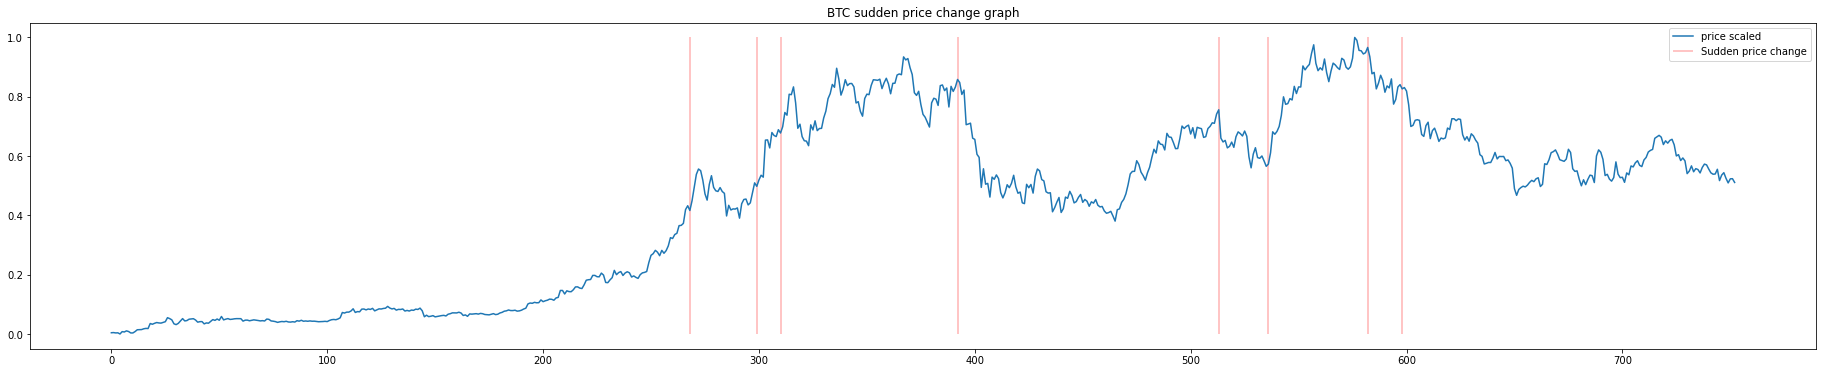

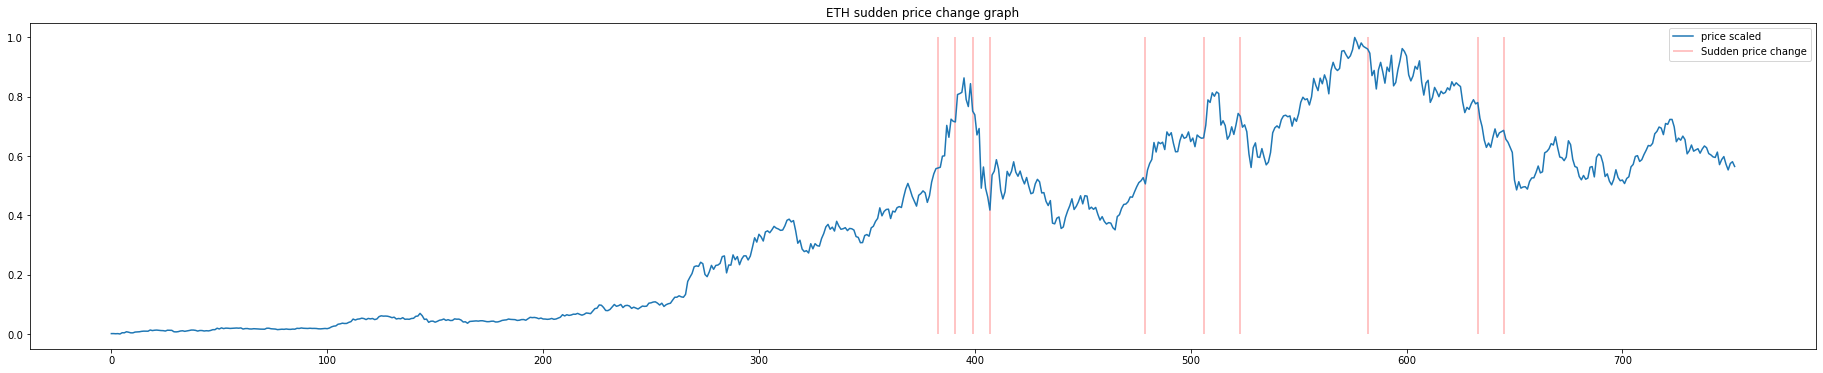

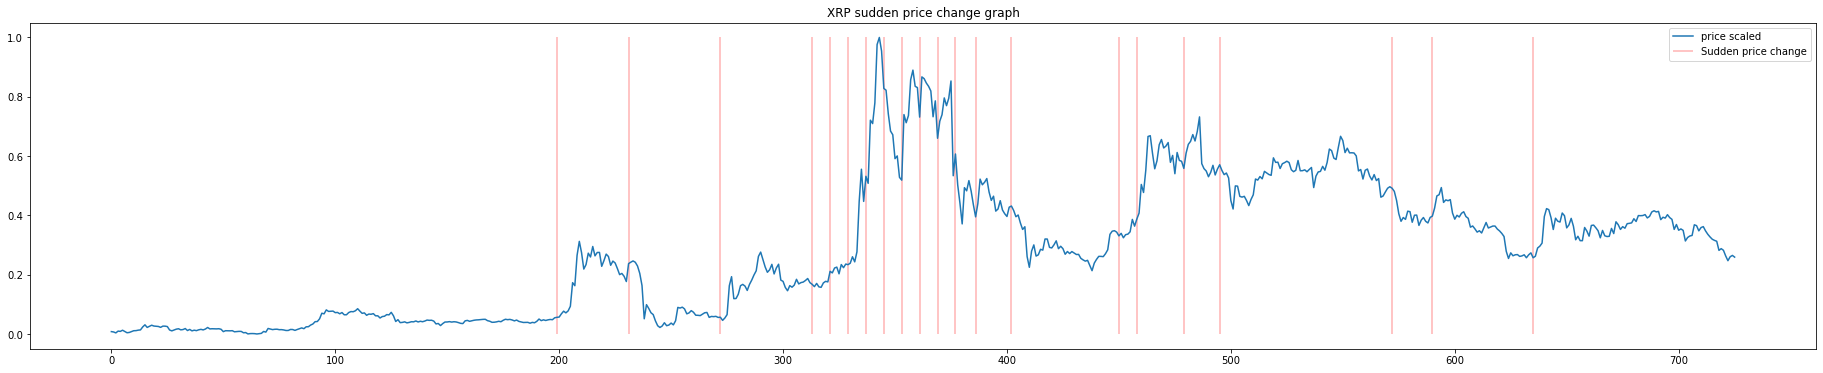

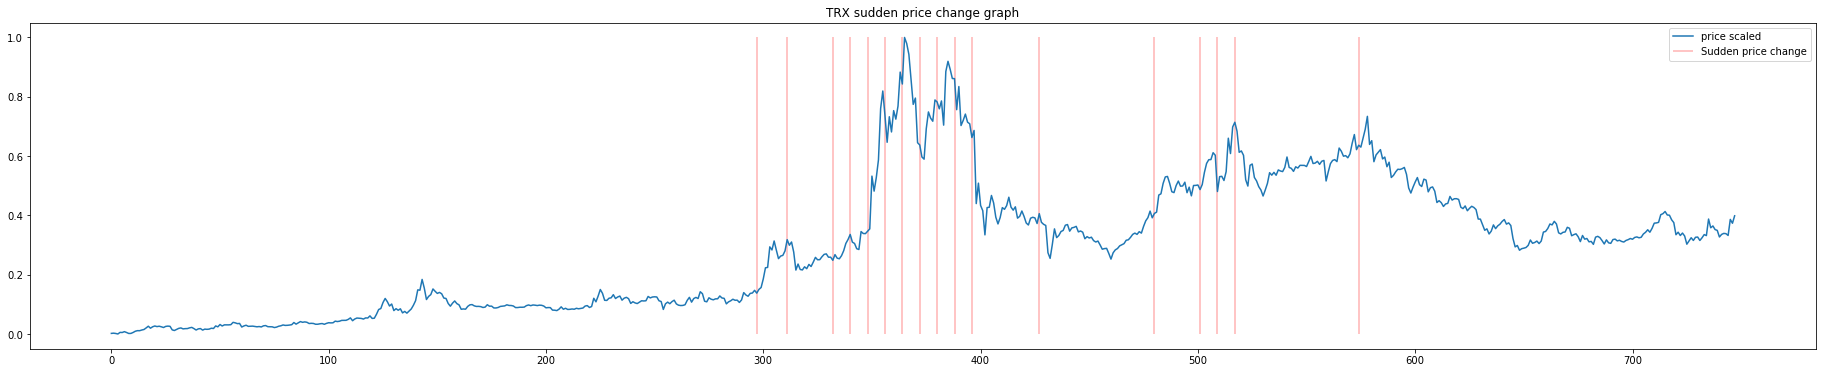

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(32,6))
plt.plot(btc["priceScaled"], label="price scaled")
plt.vlines(suddenChanges(btc), ymin=0, ymax=1, label="Sudden price change", alpha=0.3, color="r")
plt.title("BTC sudden price change graph")
plt.legend()
plt.show()

figure(figsize=(32,6))
plt.plot(eth["priceScaled"], label="price scaled")
plt.vlines(suddenChanges(eth), ymin=0, ymax=1, label="Sudden price change", alpha=0.3, color="r")
plt.title("ETH sudden price change graph")
plt.legend()
plt.show()

figure(figsize=(32,6))
plt.plot(xrp["priceScaled"], label="price scaled")
plt.vlines(suddenChanges(xrp), ymin=0, ymax=1, label="Sudden price change", alpha=0.3, color="r")
plt.title("XRP sudden price change graph")
plt.legend()
plt.show()

figure(figsize=(32,6))
plt.plot(trx["priceScaled"], label="price scaled")
plt.vlines(suddenChanges(trx), ymin=0, ymax=1, label="Sudden price change", alpha=0.3, color="r")
plt.title("TRX sudden price change graph")
plt.legend()
plt.show()

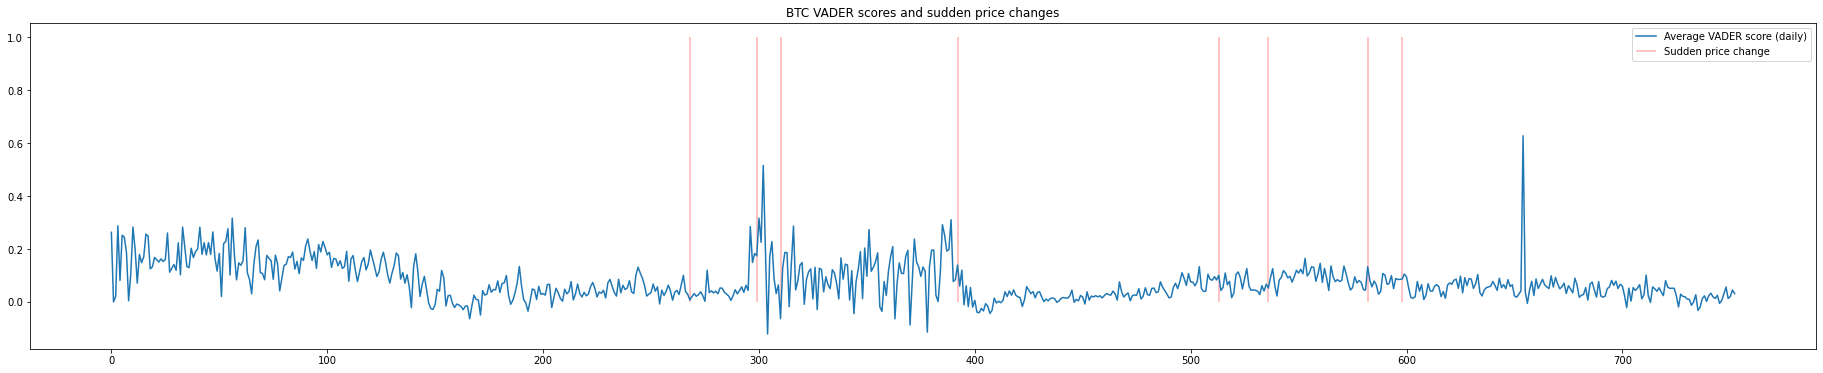

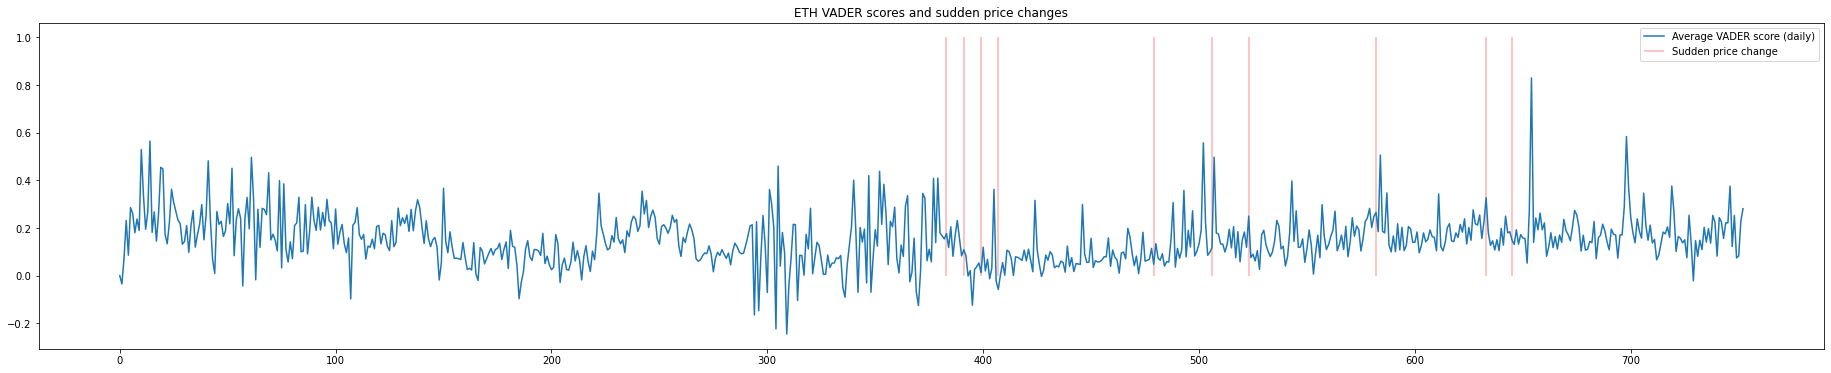

In [23]:
figure(figsize=(32,6))
plt.plot(btc["score"], label ="Average VADER score (daily)")
plt.vlines(suddenChanges(btc), ymin=0, ymax=1, label="Sudden price change", alpha=0.3, color="r")
plt.title("BTC VADER scores and sudden price changes")
plt.legend()
plt.show()

figure(figsize=(32,6))
plt.plot(eth["score"], label ="Average VADER score (daily)")
plt.vlines(suddenChanges(eth), ymin=0, ymax=1, label="Sudden price change", alpha=0.3, color="r")
plt.title("ETH VADER scores and sudden price changes")
plt.legend()
plt.show()

## References<a class="anchor" id="references"></a>

<b>1.</b> Sabry, Farida & Labda, Wadha & Erbad, Aiman & Malluhi, Qutaibah. (2020). Cryptocurrencies and Artificial Intelligence: Challenges and Opportunities. IEEE Access. 8. 175840 - 175858. 10.1109/ACCESS.2020.3025211.
 
<b>2.</b> I. Georgoula, D. Pournarakis, C. Bilanakos, N. D. Sotiropoulos, and M. G. Giaglis, ‘‘Using time-series and sentiment analysis to detect the determinants of bitcoin prices,’’ in Proc. Mediterranean Conf. Inf. Syst. (MCIS), 2015, p. 20. [Online]. Available: http://aisel. aisnet.org/mcis2015/20 
 
<b>3.</b> J. Abraham, D. Higdon, J. Nelson, and J. Ibarra, ‘‘Cryptocurrency price prediction using tweet vol. and, sentiment analysis,’’ SMU Data Sci. Rev., vol. 1, no. 3, pp. 37–73, 2018. 

<b>4.</b> Y. B. Kim, J. Lee, N. Park, J. Choo, J.-H. Kim, and C. H. Kim, ‘‘When bitcoin encounters information in an online forum: Using text mining to analyse user opinions and predict value fluctuation,’’ PLoS ONE, vol. 12, no. 5, pp. 1–14, May 2017. 

<b>5.</b> Y. B. Kim, J. G. Kim, W. Kim, J. H. Im, T. H. Kim, S. J. Kang, and C. H. Kim, ‘‘Predicting fluctuations in cryptocurrency transactions based on user comments and replies,’’ PLoS ONE, vol. 11, no. 8, pp. 1–17, Aug. 2016. 
F. Kjærland, M. Meland, A. Oust, and V. Øyen, ‘‘How can bitcoin price fluctuations be explained,’’ Int. J. Econ. Financial Issues, vol. 8, no. 3, pp. 323–332, 2018.

<b>6.</b> Zhang, Xun & Lu, Fengbin & Tao, Rui & Wang, Shouyang. (2021). The time-varying causal relationship between the Bitcoin market and internet attention. Financial Innovation. 7. 10.1186/s40854-021-00275-9. 

<b>7.</b> Santiment. [Online]. Available:  https://santiment.net

<b>8.</b> Augmento. https://www.augmento.ai

<b>9.</b> Augmento Bitcoin sentiment – Bull & Bear Index. [Online]. Available:https://www.augmento.ai/bitcoin-sentiment/

<b>10.</b> Liu, Bing. (2012). Sentiment Analysis and Opinion Mining. Synthesis Lectures on Human Language Technologies. 5. doi:10.2200/S00416ED1V01Y201204HLT016. 

<b>11.</b> Pragnya, Swayanshu Shanti. (January 2022). VADER (Valence Aware Dictionary and sentiment Reasoner) Sentiment Analysis [Medium - Blog Post]. Available:https://medium.com/mlearning-ai/vader-valence-aware-dictionary-and-sentiment-reasoner-sentiment-analysis-28251536698

<b>12.</b> What are the most challenging issues in Sentiment Analysis(opinion mining)? [Stackoverflow Question]  Available: https://stackoverflow.com/questions/4806176/what-are-the-most-challenging-issues-in-sentiment-analysisopinion-mining

<b>13.</b> Binance Telegram Group. Available: https://t.me/binanceexchange

<b>14.</b> Kucoin Telegram Group. Available: https://t.me/Kucoin_Exchange

<b>15.</b> Bittrex Telegram Group. Available: https://t.me/BittrexGlobalEnglish

<b>16.</b> Okex Telegram Group. Available: https://t.me/OKXOfficial_English

<b>17.</b> Huobi Telegram Group. Available: https://t.me/huobiglobalofficial

<b>18.</b> Brass Telegram Group. Available: https://t.me/Brass_Exchange_Chat

<b>19.</b>  Yousefi, Amir. telegram-analysis. [Github Repository] Available: https://github.com/amiryousefi/telegram-analysis/blob/master/ChannelMessages.py

<b>20.</b> Trends in crypto space (Telegram analysis). [Kaggle Dataset]. Available:https://www.kaggle.com/code/aagghh/trends-in-crypto-space-telegram-analysis/data

<b>21.</b> Crypto Data Download. [Online] Available: https://www.cryptodatadownload.com

<b>22.</b>  Hutto, C.J. & Gilbert, Eric. (2015). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Proceedings of the 8th International Conference on Weblogs and Social Media, ICWSM 2014. 

<b>23.</b> Yang, Chelsea. (2019). How to use news articles to predict BTC price changes. [Medium - Blog Post]. Available:https://towardsdatascience.com/how-to-use-news-articles-to-predict-btc-price-changes-c37e305a97f


**Disclaimer!** <font color='grey'>This notebook was prepared by Cihad Özcan & Ali Argun Sayılgan as a term project for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>